In [1]:
import numpy as np
import matplotlib.pyplot as plt
from readers.holo_reader import HoloReader
from writers.video_writer import write_video
from compute.space_transforms.fresnel import fresnel_transform
from compute.time_transforms.pca import pca

Frame dimensions: 512 x 320


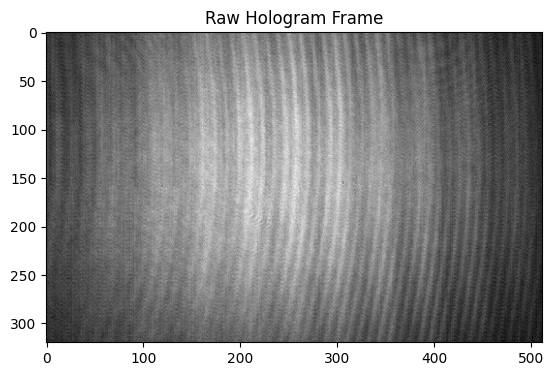

In [2]:
filename = "E:\\250512\\250512_GUJ_L.holo"
reader = HoloReader(filename, load_all_file=False)
print("Frame dimensions:", reader.frame_width, "x", reader.frame_height)

batch = reader.read_frame_batch(batch_size=32, frame_position=1)

plt.imshow(np.abs(batch[0]), cmap='gray')
plt.title("Raw Hologram Frame")
plt.show()

Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False


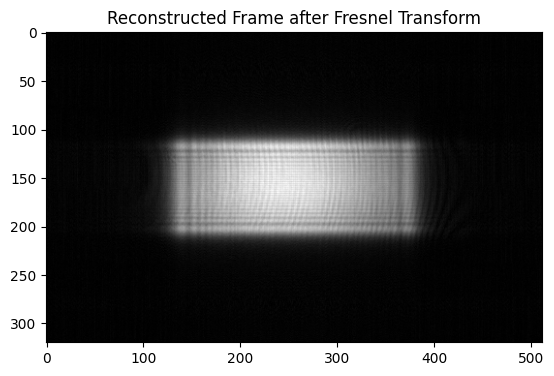

In [3]:
batch = fresnel_transform(
        frames=batch,
        z=reader.footer['compute_settings']['image_rendering']['propagation_distance'],
        wavelength=reader.footer['compute_settings']['image_rendering']['lambda'],
        x_step=reader.footer['info']['pixel_pitch']['x'] * 1e-6,
        y_step=reader.footer['info']['pixel_pitch']['y'] * 1e-6,
        use_double_precision=False
    )
    
batch = np.fft.fftshift(batch, axes=(-2, -1))

plt.imshow(np.abs(batch[0]), cmap='gray')
plt.title("Reconstructed Frame after Fresnel Transform")
plt.show()

PCA Transform H shape: (32, 320, 512)


Text(0.5, 1.0, 'First Principal Component Frame')

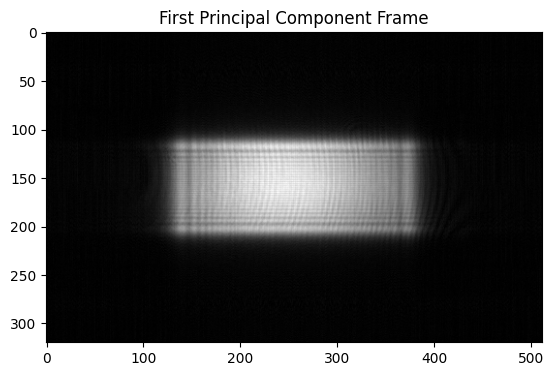

In [4]:
from compute.time_transforms.pca import pca
batch = pca(batch)

plt.imshow(np.abs(batch[0]), cmap='gray')
plt.title("First Principal Component Frame")

Text(0.5, 1.0, 'Tenth Principal Component Frame')

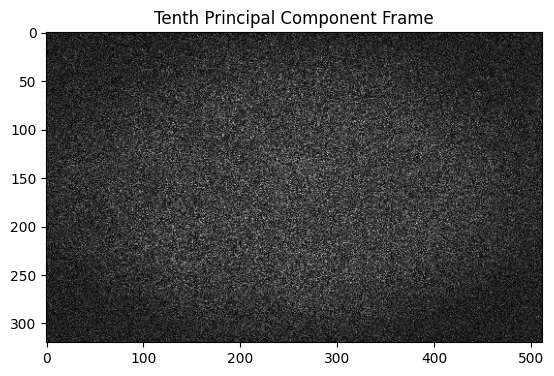

In [5]:

plt.imshow(np.abs(batch[10]), cmap='gray')
plt.title("Tenth Principal Component Frame")

Average frame shape: (320, 512)


Text(0.5, 1.0, 'Average Frame across Principal Components')

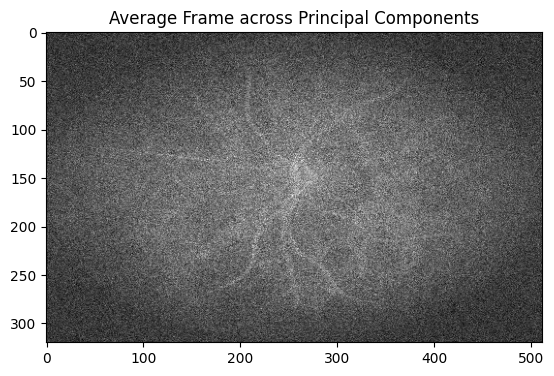

In [6]:
from postprocessing.batch_average import batch_average
avg_frame = batch_average(batch, start=16, end=32)
print("Average frame shape:", avg_frame.shape)
plt.imshow(avg_frame, cmap='gray')
plt.title("Average Frame across Principal Components")      

In [7]:
from postprocessing.normalize import normalize_frames


total = []
for i in range(32):
    batch  = reader.read_frame_batch(batch_size=32, frame_position=i*32+1)
    space_tranformed = fresnel_transform(
        frames=batch,
        z=reader.footer['compute_settings']['image_rendering']['propagation_distance'],
        wavelength=reader.footer['compute_settings']['image_rendering']['lambda'],
        x_step=reader.footer['info']['pixel_pitch']['x'] * 1e-6,
        y_step=reader.footer['info']['pixel_pitch']['y'] * 1e-6,
        use_double_precision=False
    )
    space_tranformed = np.fft.fftshift(space_tranformed, axes=(-2, -1))
    time_transformed = pca(space_tranformed)
    normalized = normalize_frames(time_transformed)
    avg_frame = batch_average(normalized, start=16, end=32)
    total.append(avg_frame)

total = np.array(total)



Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
PCA Transform H shape: (32, 320, 512)
Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
PCA Transform H shape: (32, 320, 512)
Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
PCA Transform H shape: (32, 320, 512)
Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
PCA Transform H shape: (32, 320, 512)


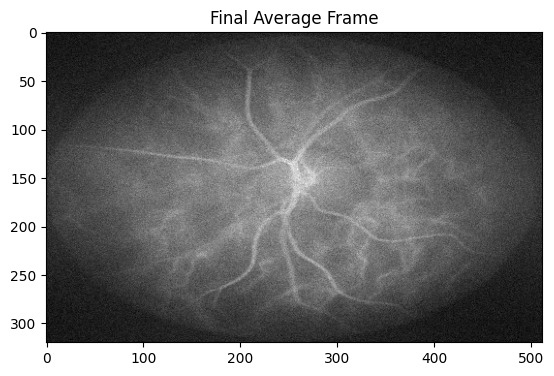

In [8]:
avg = batch_average(total)

plt.imshow(avg, cmap='gray')
plt.title("Final Average Frame")
plt.show()

In [9]:
from pathlib import Path
from writers.video_writer import write_video

# Get the current working directory of the notebook
notebook_dir = Path().resolve()
save_path = notebook_dir / "../output/output_video.avi"   # include extension!
print("Saving video to:", save_path)

write_video(total, str(save_path), fps=30, format='avi')


Saving video to: C:\STAGE\Python\PyDoppler\src\..\output\output_video.avi
Video saved: output/C:\STAGE\Python\PyDoppler\src\..\output\output_video.avi (avi, 32 frames, 30 FPS)
